# FuXi SEEPS from IMERG

In [1]:
import os
import sys
import yaml
from glob import glob
from datetime import datetime, timedelta

import numpy as np
import xarray as xr
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
sys.path.insert(0, os.path.realpath('../libs/'))
import verif_utils as vu
import seeps_utils as seeps

In [4]:
config_name = os.path.realpath('verif_config.yml')

with open(config_name, 'r') as stream:
    conf = yaml.safe_load(stream)

In [39]:
model_name = 'fuxi_mlevel_physics'
lead_range = conf[model_name]['lead_range']
verif_lead_range = conf[model_name]['verif_lead_range']

leads_exist = list(np.arange(lead_range[0], lead_range[-1]+lead_range[0], lead_range[0]))
leads_verif = list(np.arange(verif_lead_range[0], verif_lead_range[-1]+verif_lead_range[0], verif_lead_range[0]))
ind_lead = vu.lead_to_index(leads_exist, leads_verif)

print('Verifying lead times: {}'.format(leads_verif))
print('Verifying lead indices: {}'.format(ind_lead))

Verifying lead times: [6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78, 84, 90, 96, 102, 108, 114, 120, 126, 132, 138, 144, 150, 156, 162, 168, 174, 180, 186, 192, 198, 204, 210, 216, 222, 228, 234, 240, 246, 252, 258, 264, 270, 276, 282, 288, 294, 300, 306, 312, 318, 324, 330, 336, 342, 348, 354, 360]
Verifying lead indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]


In [40]:
verif_ind_start = 0; verif_ind_end = 1462
path_verif = conf[model_name]['save_loc_verif']+'combined_IMERG_{:04d}_{:04d}_{:03d}h_{:03d}h_{}.nc'.format(
    verif_ind_start, verif_ind_end, verif_lead_range[0], verif_lead_range[-1], model_name)

## Verification setup

In [41]:
ds_clim = xr.open_dataset(
    '/glade/campaign/cisl/aiml/ksha/CREDIT_physics/VERIF/ERA5_clim/IMERG_clim_2000_2020_SEEPS.nc'
)
#/glade/campaign/cisl/aiml/ksha/CREDIT_physics/VERIF/ERA5_clim/ERA5_clim_1990_2019_SEEPS.nc
seeps_calc = seeps.SpatialSEEPS(climatology=ds_clim, precip_name='total_precipitation')

In [42]:
# ---------------------------------------------------------------------------------------- #
# ERA5 verif target
filename_ERA5 = sorted(glob('/glade/campaign/cisl/aiml/ksha/IMERG_V7/GPM_3B_V07/year_*_1deg_interp.zarr'))

# pick years
year_range = conf['ERA5_ours']['year_range']
years_pick = np.arange(year_range[0], year_range[1]+1, 1).astype(str)
filename_ERA5 = [fn for fn in filename_ERA5 if any(year in fn for year in years_pick)]

# merge yearly ERA5 as one
ds_ERA5 = [vu.get_forward_data(fn) for fn in filename_ERA5]
ds_ERA5_merge = xr.concat(ds_ERA5, dim='time')

# ---------------------------------------------------------------------------------------- #
# forecast
filename_OURS = sorted(glob(conf[model_name]['save_loc_gather']+'*.nc'))

# pick years
year_range = conf[model_name]['year_range']
years_pick = np.arange(year_range[0], year_range[1]+1, 1).astype(str)
filename_OURS = [fn for fn in filename_OURS if any(year in fn for year in years_pick)]

filename_OURS = filename_OURS[verif_ind_start:verif_ind_end]
filename_OURS = [fn for fn in filename_OURS if '00Z' in fn]

# latitude weighting
lat = xr.open_dataset(filename_OURS[0])["latitude"]
w_lat = np.cos(np.deg2rad(lat))
w_lat = w_lat / w_lat.mean()

In [43]:
variable_levels = {
    'total_precipitation': None,
}

In [44]:
# ---------------------------------------------------------------------------------------- #
# RMSE compute
verif_results = []

for fn_ours in filename_OURS:
    # detect 00Z vs 12Z
    ini = int(fn_ours[-6:-4])
    
    ds_ours = xr.open_dataset(fn_ours)
    ds_ours = ds_ours.isel(time=ind_lead)
    ds_ours = vu.ds_subset_everything(ds_ours, variable_levels)
    
    # ------------------------------------------- #
    # convert neg precip to 0 before accumulation 
    ds_ours['total_precipitation'] = xr.where(
        ds_ours['total_precipitation'] < 0, 0, ds_ours['total_precipitation']
    )
    ds_ours_24h = vu.accum_6h_24h(ds_ours, ini)
    ds_ours_24h = ds_ours_24h.compute()

    ds_target = ds_ERA5_merge.sel(time=ds_ours_24h['time'])
    ds_target = vu.ds_subset_everything(ds_target, variable_levels)
    ds_target_24h = ds_target.compute()
    
    # SEEPS
    seeps_score = seeps_calc.compute_chunk(ds_ours_24h, ds_target_24h)
    seeps_score_mean = (w_lat * seeps_score).mean(['latitude', 'longitude'])
    
    verif_results.append(seeps_score_mean.drop_vars('time'))
    
# Combine verif results
ds_verif_24h = xr.concat(verif_results, dim='days')

# # Save the combined dataset
# print('Save to {}'.format(path_verif))
# #ds_verif_24h.to_netcdf(path_verif)

### Testing SEEPS spatial vals

In [45]:
test = seeps_score['total_precipitation'].values[0, ...]

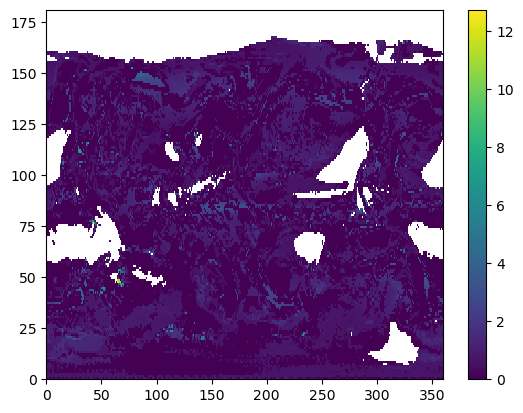

In [46]:
plt.pcolormesh(test)
plt.colorbar()